# Import

In [3]:
import os
import cv2
import glob
import re
import numpy as np
import seaborn as sns
import pandas as pd
import time
import mnist_reader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from skimage.feature import hog
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, precision_score, recall_score, f1_score


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical



# Get Images and Labels 

In [4]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [5]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)


In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# 3.1. MLP applied on selected features

### Feature Extraction: HOG and PCA

In [7]:
def extract_hog_features(X):
    hog_features = []
    for image in X:
        feature = hog(image.reshape(28, 28),
                      pixels_per_cell=(4, 4), 
                      cells_per_block=(2, 2), 
                      orientations=9, 
                      block_norm='L2-Hys')
        hog_features.append(feature)
    return np.array(hog_features)

In [8]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

X_train_hog[0].reshape(1,-1).shape

(1, 1296)

In [9]:
pca_percentage = 0.95
pca = PCA(pca_percentage)

X_train_pca = pca.fit_transform(X_train_hog)
X_test_pca = pca.transform(X_test_hog)

In [10]:
print("Cumulative Variance Explained by PCA", np.sum(pca.explained_variance_ratio_))

Cumulative Variance Explained by PCA 0.950161012576859


In [14]:
print("X_train_hog:", X_train_hog.shape)
print("X_test_hog:", X_test_hog.shape)
print("X_train_pca:", X_train_pca.shape)
print("X_test_pca:", X_test_pca.shape)

X_train_hog: (60000, 1296)
X_test_hog: (10000, 1296)
X_train_pca: (60000, 354)
X_test_pca: (10000, 354)


### Feature selection

In [15]:
def select_features_with_percentile(X, y, num_features=64):
    selector = SelectKBest(score_func=f_classif, k=num_features)
    X_new = selector.fit_transform(X, y)
    return X_new

In [16]:
X_train_reduced = select_features_with_percentile(X_train_pca, y_train, num_features=64)
X_test_reduced = select_features_with_percentile(X_test_pca, y_test, num_features=64)

print("Dimensiunea nouă a setului de date:", X_train_reduced.shape, X_test_reduced.shape)


Dimensiunea nouă a setului de date: (60000, 64) (10000, 64)


### Data Normalization using StandarScaler

In [17]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_test_normalized = scaler.transform(X_test_reduced)


### Validation Set

In [18]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_normalized, y_train, test_size=0.2, random_state=42
)

print(f"Training Set Size (0.8): {X_train_small.shape}")
print(f"Validation Set Size (0.2): {X_val.shape}")

print(f"Original Train Set Shape: {X_train_normalized.shape}")
print(f"Test Set Shape: {X_test_normalized.shape}")

Training Set Size (0.8): (48000, 64)
Validation Set Size (0.2): (12000, 64)
Original Train Set Shape: (60000, 64)
Test Set Shape: (10000, 64)


### MLP on selected features

In [19]:
mlp = Sequential([
    Dense(512, input_shape=(64,)),  # Input layer with 512 units
    Activation('relu'),             # ReLU activation
    Dropout(0.3),                   # Dropout for regularization
    Dense(512),                     # Hidden layer with 512 units
    Activation('relu'),             # ReLU activation
    Dropout(0.3),                   # Dropout for regularization
    Dense(10),                      # Output layer with 10 units (num_classes)
    Activation('softmax')           # Softmax activation for probabilities
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
filepath = "mlp-weights.{epoch:02d}-{val_loss:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


### Transforming labels into one-hot encoding format

In [ ]:
y_train_small_one_hot = to_categorical(y_train_small, num_classes=10)
y_val_one_hot = to_categorical(y_val, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

print("Shape of y_train_small_one_hot:", y_train_small_one_hot.shape)
print("Shape of y_val_one_hot:", y_val_one_hot.shape)
print("Shape of y_test_one_hot:", y_test_one_hot.shape)

Shape of y_train_small_one_hot: (48000, 10)
Shape of y_val_one_hot: (12000, 10)
Shape of y_test_one_hot: (10000, 10)


### Training the MLP model

In [25]:
start_time = time.time()
history_mlp = mlp.fit(
    X_train_small,                # 80% X_train_normalized
    y_train_small_one_hot,        
    batch_size=128,              
    epochs=25,               
    verbose=1,               
    validation_data=(X_val, y_val_one_hot)  
)
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")


Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7665 - loss: 0.7301 - val_accuracy: 0.8775 - val_loss: 0.3315
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8762 - loss: 0.3410 - val_accuracy: 0.8842 - val_loss: 0.3068
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8892 - loss: 0.2961 - val_accuracy: 0.8955 - val_loss: 0.2897
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8955 - loss: 0.2820 - val_accuracy: 0.8942 - val_loss: 0.2844
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9014 - loss: 0.2607 - val_accuracy: 0.8976 - val_loss: 0.2797
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9088 - loss: 0.2462 - val_accuracy: 0.8977 - val_loss: 0.2792
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9126 - loss: 0.2319 - val_accuracy: 0.8951 - val_loss: 0.2779
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9127 - loss: 0.2253 - val_accuracy: 0.

In [26]:
best_score = max(history_mlp.history['val_accuracy'])
best_epoch = np.array(history_mlp.history['val_accuracy']).argmax()+1
print('Best test accuracy was %f at epoch %i' % (best_score, best_epoch))

Best test accuracy was 0.898583 at epoch 9


### Table Report

In [27]:
test_loss_mlp, test_accuracy_mlp = mlp.evaluate(X_test_normalized, y_test_one_hot, verbose=1)
print(f"Test Loss: {test_loss_mlp}")
print(f"Test Accuracy: {test_accuracy_mlp}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.8771 - loss: 0.3932
Test Loss: 0.401432067155838
Test Accuracy: 0.8773999810218811


In [28]:

y_pred = mlp.predict(X_test_normalized)

y_pred_classes = y_pred.argmax(axis=1)

y_test_classes = y_test_one_hot.argmax(axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


In [29]:
print(classification_report(y_test_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.8107    0.8520    0.8308      1000
           1     0.9807    0.9670    0.9738      1000
           2     0.8203    0.8080    0.8141      1000
           3     0.8790    0.8790    0.8790      1000
           4     0.7743    0.8440    0.8077      1000
           5     0.9555    0.9450    0.9502      1000
           6     0.7117    0.6270    0.6667      1000
           7     0.9161    0.9390    0.9274      1000
           8     0.9690    0.9690    0.9690      1000
           9     0.9507    0.9440    0.9473      1000

    accuracy                         0.8774     10000
   macro avg     0.8768    0.8774    0.8766     10000
weighted avg     0.8768    0.8774    0.8766     10000



### Loss and Accuracy curves

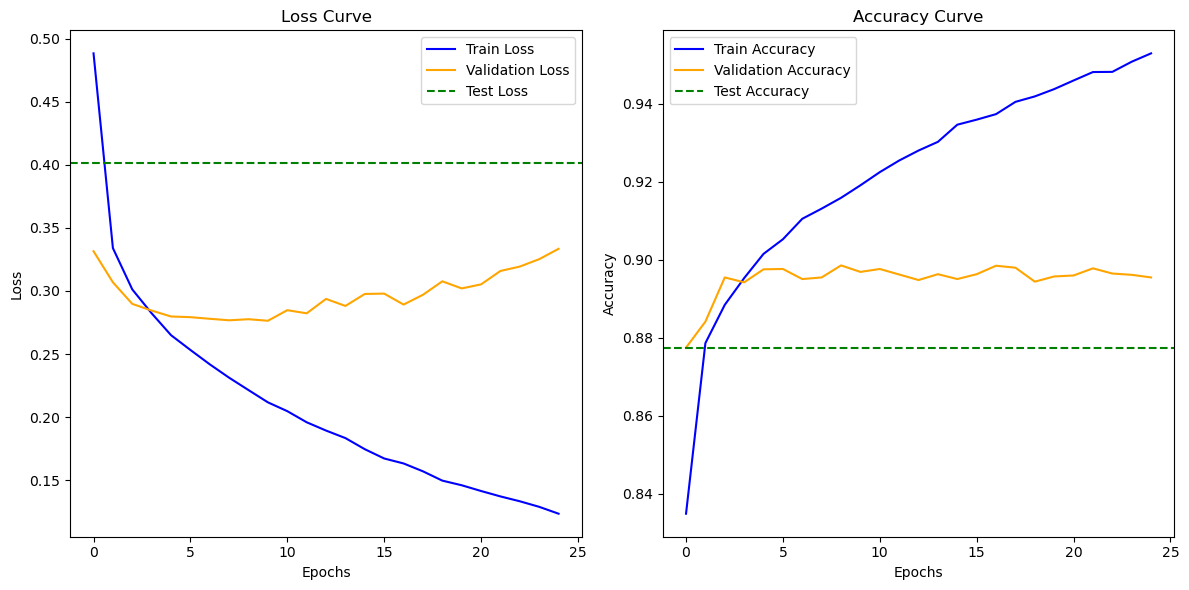

In [30]:
plt.figure(figsize=(12, 6))

#  (loss)
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Train Loss', color='blue')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss', color='orange')
plt.axhline(y=test_loss_mlp, color='green', linestyle='--', label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.axhline(y=test_accuracy_mlp, color='green', linestyle='--', label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 3.2.  MLP applied on images

### Linearization and Normalization

In [31]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # new dimension (60000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)    

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_flat)
X_test_normalized = scaler.transform(X_test_flat)


### Validation Set

In [32]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_normalized, y_train, test_size=0.2, random_state=42
)

print(f"Training Set Size (0.8): {X_train_small.shape}")
print(f"Validation Set Size (0.2): {X_val.shape}")

print(f"Original Train Set Shape: {X_train_normalized.shape}")
print(f"Test Set Shape: {X_test_normalized.shape}")

Training Set Size (0.8): (48000, 784)
Validation Set Size (0.2): (12000, 784)
Original Train Set Shape: (60000, 784)
Test Set Shape: (10000, 784)


### One_hot conversion

In [33]:
y_train_small_one_hot = to_categorical(y_train_small, num_classes=10)
y_val_one_hot = to_categorical(y_val, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

print("Shape of y_train_small_one_hot:", y_train_small_one_hot.shape)
print("Shape of y_val_one_hot:", y_val_one_hot.shape)
print("Shape of y_test_one_hot:", y_test_one_hot.shape)

Shape of y_train_small_one_hot: (48000, 10)
Shape of y_val_one_hot: (12000, 10)
Shape of y_test_one_hot: (10000, 10)


### MLP on images

In [34]:
mlp_img = Sequential([
    Dense(512, input_shape=(784,)),  # Input layer with 512 units
    Activation('relu'),             # ReLU activation
    Dropout(0.3),                   # Dropout for regularization
    Dense(512),                     # Hidden layer with 512 units
    Activation('relu'),             # ReLU activation
    Dropout(0.3),                   # Dropout for regularization
    Dense(10),                      # Output layer with 10 units (num_classes)
    Activation('softmax')           # Softmax activation for probabilities
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
mlp_img.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the MLP on images

In [36]:
start_time = time.time()
history_mlp_img = mlp_img.fit(
    X_train_small,                
    y_train_small_one_hot,        
    batch_size=128,               
    epochs=25,                    
    verbose=1,                   
    validation_data=(X_val, y_val_one_hot)
)
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")


Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7611 - loss: 0.6819 - val_accuracy: 0.8585 - val_loss: 0.3937
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8564 - loss: 0.3921 - val_accuracy: 0.8767 - val_loss: 0.3352
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8696 - loss: 0.3522 - val_accuracy: 0.8792 - val_loss: 0.3300
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8824 - loss: 0.3177 - val_accuracy: 0.8808 - val_loss: 0.3226
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8873 - loss: 0.3043 - val_accuracy: 0.8848 - val_loss: 0.3125
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8906 - loss: 0.2884 - val_accuracy: 0.8838 - val_loss: 0.3230
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8994 - loss: 0.2733 - val_accuracy: 0.8822 - val_loss: 0.3181
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8988 - loss: 0.2688 - val_accuracy: 0.

In [37]:
best_score = max(history_mlp_img.history['val_accuracy'])
best_epoch = np.array(history_mlp_img.history['val_accuracy']).argmax()+1
print('Best test accuracy was %f at epoch %i' % (best_score, best_epoch))

Best test accuracy was 0.898417 at epoch 24


### Table Report

In [38]:
test_loss_mlp_img, test_accuracy_mlp_img = mlp_img.evaluate(X_test_normalized, y_test_one_hot, verbose=1)
print(f"Test Loss: {test_loss_mlp_img}")
print(f"Test Accuracy: {test_accuracy_mlp_img}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8982 - loss: 0.3692
Test Loss: 0.37272408604621887
Test Accuracy: 0.8948000073432922


In [39]:
y_pred = mlp_img.predict(X_test_normalized)

y_pred_classes = y_pred.argmax(axis=1)

y_test_classes = y_test_one_hot.argmax(axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [40]:
print(classification_report(y_test_classes, y_pred_classes, digits=4))


              precision    recall  f1-score   support

           0     0.8541    0.8430    0.8485      1000
           1     0.9869    0.9820    0.9845      1000
           2     0.8254    0.8180    0.8217      1000
           3     0.8719    0.9260    0.8982      1000
           4     0.8186    0.8440    0.8311      1000
           5     0.9665    0.9530    0.9597      1000
           6     0.7476    0.7110    0.7289      1000
           7     0.9454    0.9530    0.9492      1000
           8     0.9846    0.9560    0.9701      1000
           9     0.9450    0.9620    0.9534      1000

    accuracy                         0.8948     10000
   macro avg     0.8946    0.8948    0.8945     10000
weighted avg     0.8946    0.8948    0.8945     10000



### Loss and Accuracy curves

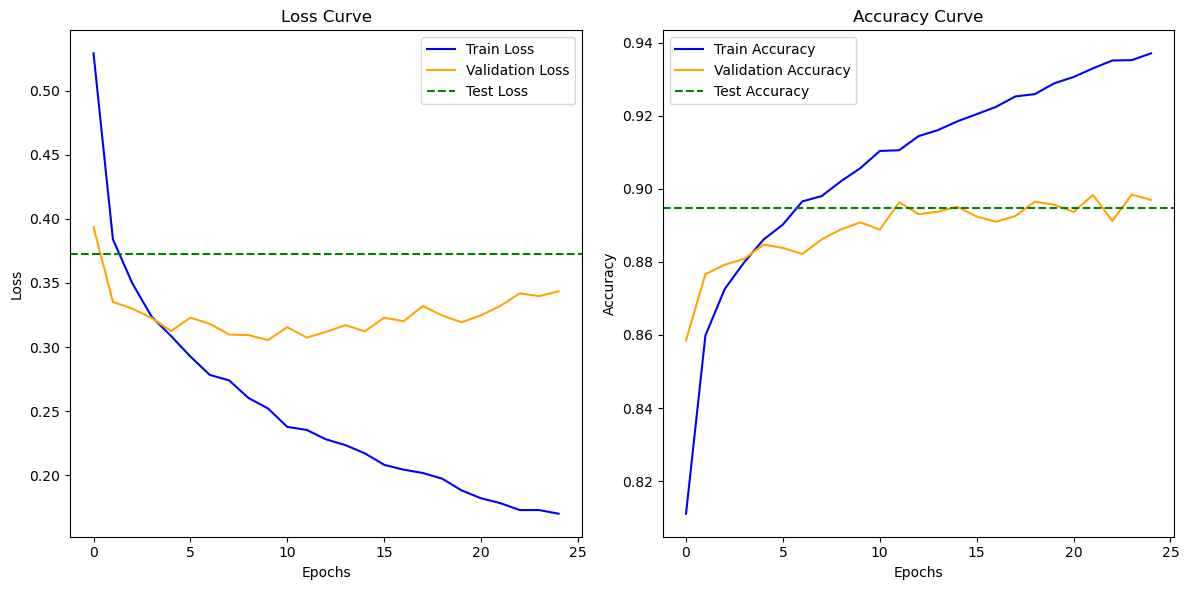

In [41]:
plt.figure(figsize=(12, 6))

#  (loss)
plt.subplot(1, 2, 1)
plt.plot(history_mlp_img.history['loss'], label='Train Loss', color='blue')
plt.plot(history_mlp_img.history['val_loss'], label='Validation Loss', color='orange')
plt.axhline(y=test_loss_mlp_img, color='green', linestyle='--', label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_mlp_img.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_mlp_img.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.axhline(y=test_accuracy_mlp_img, color='green', linestyle='--', label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 3.3. CNN

### Image normalization [0,1]

In [42]:
X_train_reshaped = X_train.reshape(-1, 28, 28, 1) # with grayscale channel
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)


In [43]:
X_train_normalized = X_train_reshaped / 255.0
X_test_normalized = X_test_reshaped / 255.0

In [44]:
print(X_train_normalized.shape)

(60000, 28, 28, 1)


### Validation Set

In [45]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_normalized, y_train, test_size=0.2, random_state=42
)

print(f"Training Set Size (0.8): {X_train_small.shape}")
print(f"Validation Set Size (0.2): {X_val.shape}")

print(f"Original Train Set Shape: {X_train_normalized.shape}")
print(f"Test Set Shape: {X_test_normalized.shape}")

Training Set Size (0.8): (48000, 28, 28, 1)
Validation Set Size (0.2): (12000, 28, 28, 1)
Original Train Set Shape: (60000, 28, 28, 1)
Test Set Shape: (10000, 28, 28, 1)


### CNN definition

In [46]:
# DeepConvNet-like architecture
def create_cnn_model():
    model = Sequential([
        # layer 1 - convolutional
        Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(),
        Activation('relu'),

        # layer 2 - convolutional
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        # layer 3 - convolutional
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        # Global Average Pooling
        GlobalAveragePooling2D(),

        # Fully Connected Layer (Linear)
        Dense(256, activation='relu'),
        Dropout(0.5),

        # Output Layer (Softmax)
        Dense(10, activation='softmax')  # 10 classes
    ])
    return model

## A. CNN on original dataset

In [47]:
model_without_aug = create_cnn_model()

model_without_aug.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])


start_time = time.time()
history_without_aug = model_without_aug.fit(
    X_train_small, y_train_small,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    verbose=1
)
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 216ms/step - accuracy: 0.5492 - loss: 1.2387 - val_accuracy: 0.1430 - val_loss: 5.9293
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 216ms/step - accuracy: 0.7833 - loss: 0.5989 - val_accuracy: 0.7821 - val_loss: 0.6125
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 348s 930ms/step - accuracy: 0.8207 - loss: 0.5004 - val_accuracy: 0.5066 - val_loss: 2.0927
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 211ms/step - accuracy: 0.8424 - loss: 0.4459 - val_accuracy: 0.7462 - val_loss: 0.7153
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 214ms/step - accuracy: 0.8510 - loss: 0.4213 - val_accuracy: 0.2534 - val_loss: 4.3578
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 86s 231ms/step - accuracy: 0.8622 - loss: 0.3961 - val_accuracy: 0.8139 - val_loss: 0.5191
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 90s 240ms/step - accuracy: 0.8654 - loss: 0.3816 - val_accuracy: 0.6347 - val_loss: 1.0408
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 86s 228ms/step - accuracy: 0.8731 - loss: 

### Table Report

In [48]:
test_loss_no_aug, test_accuracy_no_aug = model_without_aug.evaluate(
    X_test_normalized, y_test, verbose=0
)

print(f"Test Loss (No Augmentation): {test_loss_no_aug}")
print(f"Test Accuracy (No Augmentation): {test_accuracy_no_aug}")


Test Loss (No Augmentation): 0.6711156964302063
Test Accuracy (No Augmentation): 0.786899983882904


In [49]:
y_pred = model_without_aug.predict(X_test_normalized)

y_pred_classes = y_pred.argmax(axis=1)

y_test_classes = y_test_one_hot.argmax(axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


In [50]:
print(classification_report(y_test_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.6439    0.9060    0.7528      1000
           1     0.9908    0.9660    0.9782      1000
           2     0.5749    0.9560    0.7180      1000
           3     0.9280    0.6700    0.7782      1000
           4     0.7867    0.6160    0.6910      1000
           5     0.9850    0.6550    0.7868      1000
           6     0.8466    0.2980    0.4408      1000
           7     0.6561    0.9960    0.7911      1000
           8     0.9577    0.9510    0.9543      1000
           9     0.9273    0.8550    0.8897      1000

    accuracy                         0.7869     10000
   macro avg     0.8297    0.7869    0.7781     10000
weighted avg     0.8297    0.7869    0.7781     10000



## B. CNN on augmented dataset

### Data Augmentation

In [51]:
# definition
data_augmentation = ImageDataGenerator(
    rotation_range=15,            
    width_shift_range=0.1,         
    height_shift_range=0.1,
    horizontal_flip=True,          
    rescale=1.0                    
)

In [52]:
train_generator = data_augmentation.flow(
    X_train_small, y_train_small, batch_size=128
)

### Compile and Train CNN with augmented data

In [53]:

model_with_aug = create_cnn_model()

model_with_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()
history_with_aug = model_with_aug.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=20,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 216ms/step - accuracy: 0.5077 - loss: 1.3246 - val_accuracy: 0.1330 - val_loss: 6.7426
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.7350 - loss: 0.7405 - val_accuracy: 0.6387 - val_loss: 0.9945
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 211ms/step - accuracy: 0.7732 - loss: 0.6307 - val_accuracy: 0.6158 - val_loss: 1.0702
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 214ms/step - accuracy: 0.7922 - loss: 0.5764 - val_accuracy: 0.6295 - val_loss: 1.0288
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 223ms/step - accuracy: 0.8009 - loss: 0.5508 - val_accuracy: 0.3280 - val_loss: 3.4368
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - accuracy: 0.8091 - loss: 0.5319 - val_accuracy: 0.6640 - val_loss: 1.1731
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 238ms/step - accuracy: 0.8151 - loss: 0.5151 - val_accuracy: 0.5073 - val_loss: 1.6023
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 85s 228ms/step - accuracy: 0.8255 - loss: 0.4955 - val

### Table Report

In [54]:
test_loss_with_aug, test_accuracy_with_aug = model_with_aug.evaluate(
    X_test_normalized, y_test, verbose=0
)

print(f"Test Loss (No Augmentation): {test_loss_no_aug}")
print(f"Test Accuracy (No Augmentation): {test_accuracy_no_aug}")

Test Loss (No Augmentation): 0.6711156964302063
Test Accuracy (No Augmentation): 0.786899983882904


In [55]:

y_pred = model_with_aug.predict(X_test_normalized)

y_pred_classes = y_pred.argmax(axis=1)

y_test_classes = y_test_one_hot.argmax(axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


In [56]:
print(classification_report(y_test_classes, y_pred_classes, digits=4))


              precision    recall  f1-score   support

           0     0.8296    0.7500    0.7878      1000
           1     0.8433    0.9850    0.9087      1000
           2     0.8226    0.7280    0.7724      1000
           3     0.8833    0.7720    0.8239      1000
           4     0.7634    0.7290    0.7458      1000
           5     0.5228    0.9990    0.6864      1000
           6     0.6220    0.6270    0.6245      1000
           7     0.9782    0.3590    0.5252      1000
           8     0.9121    0.9130    0.9125      1000
           9     0.9396    0.8710    0.9040      1000

    accuracy                         0.7733     10000
   macro avg     0.8117    0.7733    0.7691     10000
weighted avg     0.8117    0.7733    0.7691     10000



## Loss and Accuracy curves for the CNN (with and without Data Augmentation)

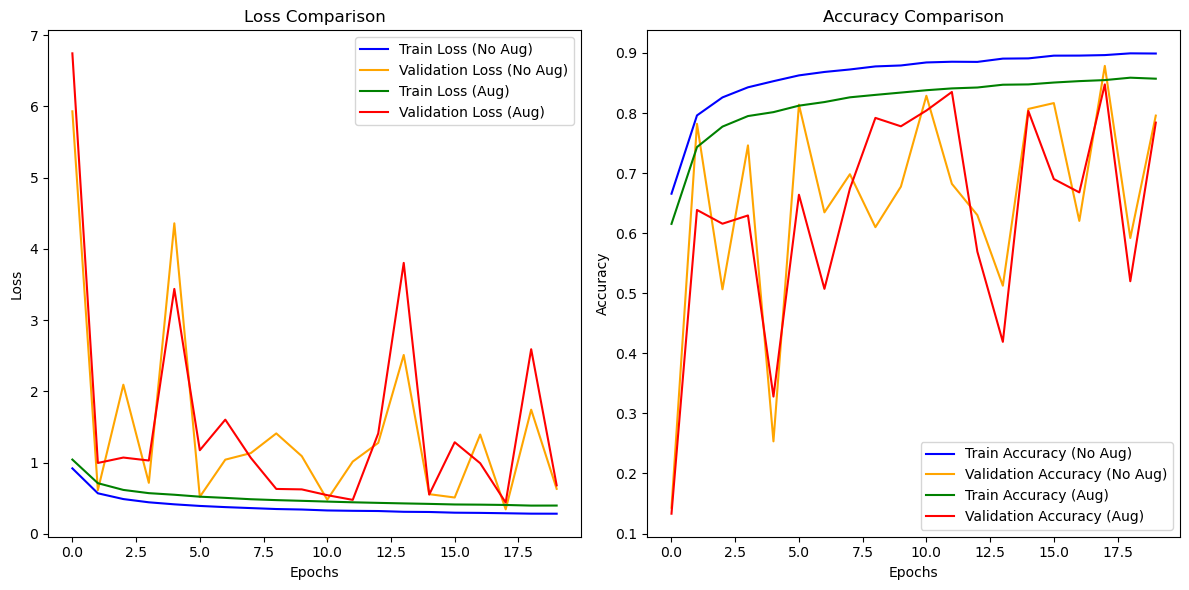

In [57]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_without_aug.history['loss'], label='Train Loss (No Aug)', color='blue')
plt.plot(history_without_aug.history['val_loss'], label='Validation Loss (No Aug)', color='orange')
plt.plot(history_with_aug.history['loss'], label='Train Loss (Aug)', color='green')
plt.plot(history_with_aug.history['val_loss'], label='Validation Loss (Aug)', color='red')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_without_aug.history['accuracy'], label='Train Accuracy (No Aug)', color='blue')
plt.plot(history_without_aug.history['val_accuracy'], label='Validation Accuracy (No Aug)', color='orange')
plt.plot(history_with_aug.history['accuracy'], label='Train Accuracy (Aug)', color='green')
plt.plot(history_with_aug.history['val_accuracy'], label='Validation Accuracy (Aug)', color='red')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# 3.4 Finetuning over ResNet-18 Architecture

### Preprocess the dataset

In [ ]:
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.Grayscale(3),     
    transforms.ToTensor(),       
    transforms.Normalize((0.5,), (0.5,))  
])

X_train_reshaped = X_train.reshape(-1, 28, 28)
X_test_reshaped = X_test.reshape(-1, 28, 28)

X_train_transformed = torch.stack([transform(img) for img in X_train_reshaped])
X_test_transformed = torch.stack([transform(img) for img in X_test_reshaped])


### Convert Labels to Tensor

In [60]:
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


### Split into train, validation, and test sets

In [77]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_transformed, y_train_tensor, test_size=0.2, random_state=42
)

print(f"Training Set Size: {X_train_small.shape}")
print(f"Validation Set Size: {X_val.shape}")

Training Set Size: torch.Size([48000, 3, 32, 32])
Validation Set Size: torch.Size([12000, 3, 32, 32])


### Create DataLoader

In [78]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_small, y_train_small)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Load Pretrained ResNet-18

In [70]:
from torchvision.models import resnet18
from torch import nn

model = resnet18(pretrained=True)


In [71]:
num_classes = 10  # Fashion-MNIST has 10 classes
model.fc = nn.Linear(model.fc.in_features, num_classes)


### Define Optimizer and Loss

In [72]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()


In [73]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
model = model.to(device)
print(f"Using device: {device}")
print(torch.backends.mps.is_available()) # true


Using device: mps
True


### Train the model

In [80]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

for epoch in range(25):
    # train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # validate
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step()

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")


Epoch 1, Train Loss: 0.0119, Train Acc: 0.9970, Val Loss: 0.0078, Val Acc: 0.9979
Epoch 2, Train Loss: 0.0124, Train Acc: 0.9966, Val Loss: 0.0077, Val Acc: 0.9982
Epoch 3, Train Loss: 0.0125, Train Acc: 0.9969, Val Loss: 0.0077, Val Acc: 0.9982
Epoch 4, Train Loss: 0.0122, Train Acc: 0.9969, Val Loss: 0.0078, Val Acc: 0.9980
Epoch 5, Train Loss: 0.0118, Train Acc: 0.9968, Val Loss: 0.0077, Val Acc: 0.9981
Epoch 6, Train Loss: 0.0126, Train Acc: 0.9968, Val Loss: 0.0077, Val Acc: 0.9982
Epoch 7, Train Loss: 0.0124, Train Acc: 0.9968, Val Loss: 0.0078, Val Acc: 0.9981
Epoch 8, Train Loss: 0.0120, Train Acc: 0.9970, Val Loss: 0.0077, Val Acc: 0.9979
Epoch 9, Train Loss: 0.0120, Train Acc: 0.9968, Val Loss: 0.0078, Val Acc: 0.9981
Epoch 10, Train Loss: 0.0125, Train Acc: 0.9968, Val Loss: 0.0077, Val Acc: 0.9980
Epoch 11, Train Loss: 0.0124, Train Acc: 0.9970, Val Loss: 0.0077, Val Acc: 0.9983
Epoch 12, Train Loss: 0.0125, Train Acc: 0.9963, Val Loss: 0.0079, Val Acc: 0.9982
Epoch 13, Tra

### Evaluate the model on the test set

In [82]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = correct / total

    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return precision, recall, f1

precision, recall, f1 = evaluate_model(model, test_loader, device)

Test Accuracy: 0.9315
Precision: 0.9313, Recall: 0.9315, F1-Score: 0.9314


### Loss and Accuracy Curves

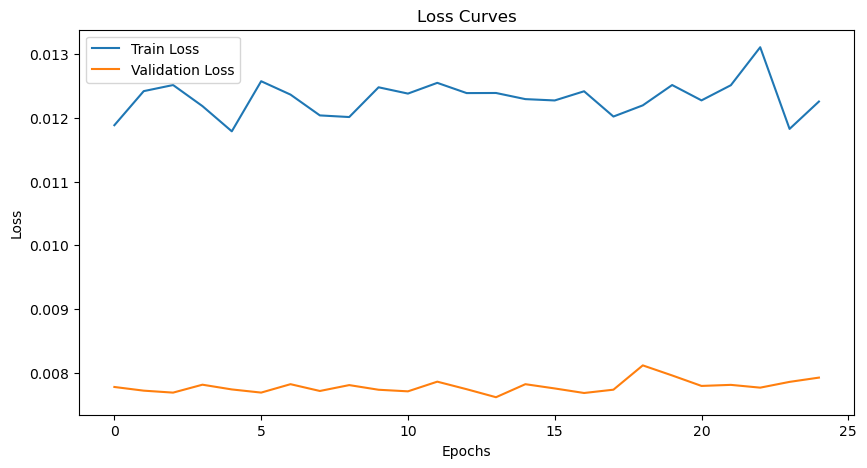

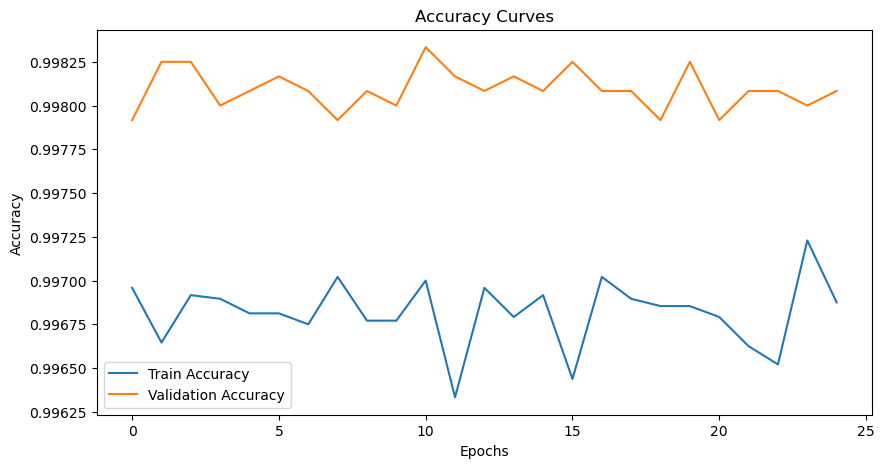

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()